In [2]:
# For display purposes
%matplotlib inline
from IPython.core.display import HTML
table_css = 'table {display: inline-block} '
HTML('<style>{}</style>'.format(table_css))

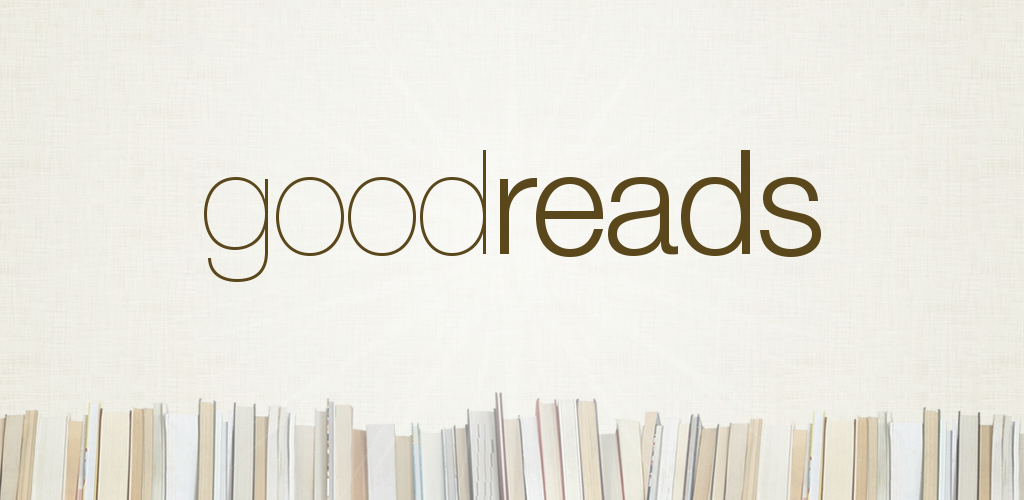

Goodreads stands as a vibrant social media hub designed exclusively for book enthusiasts, offering a dedicated space for the sharing and evaluation of literary works. Within its digital realm, a vast repository of books is meticulously cataloged, featuring essential details such as titles, authors, publishers, as well as insightful quotations and reviews contributed by the platform's active user community.

Delving into the intricacies of this literary landscape, the Goodreads.ipynb notebook embarks on a journey to unravel compelling insights. Through systematic exploration, we discover some interesting results, including how things have changed over time and how various parameters correlate. 

## Project Goal

     In this notebook, our primary goal is to investigate how these parameters are clustered by leveraging the K-Means algorithm and then use this idea to develop a book recommendation system.

# Table of contents
1. [Dataset](#dataset)
2. [Loading the dataset and modules](#loading)
3. [Pre-processing data](#pre-process)
4. [Identifying clusters in the data (K-Means Algorithm)](#K-means)


# Dataset

The raw data used here is obtained using a dedicated web scraping tool developed for this project: 
<a href="https://github.com/EmmaKLofthouse/goodreads_scraper">goodreads_scraper</a>. 

This provides the following variables for each book:

| Column             | Description                         |
|  ----------------  |   :-------  |
| title              | The book title                      |
| Number of pages    | Number of pages in the book         |
| Language           | Language of text                    |
| Author             | Author's Name                       |
| Rating Value       | Average rating. From 0 to 5         |
| Rating Count       | Total number of ratings             |
| Review Count       | Total number of written reviews     |
| ISBN               | International Standard Book Number  |                       
| Publication Date   | Date of publication                 |     

This data has been cleaned as shown in the Goodreads.ipynb notebook. 

# Load the dataset and required modules 
<a name="loading"></a>


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

First, we read in the cleaned csv file containing data on the scraped books and convert it to a pandas dataframe for easy manipulation. 

In [4]:
df = pd.read_csv('goodreads_data_clean.csv')

In [5]:
df.head()

,title,num_pages,lang,author,avg_rating,num_ratings,num_reviews,pub_date_string,pub_date,year,month,day
0,Lottery Master Guide: Turn a Game of Chance In...,192,English,Gail Howard,3.98,46,4,"First published April 1, 1997",1997-04-01,1997,4,1
1,Winning Lotto / Lottery For Everyday Players,160,English,Professor Jones,2.50,6,1,"First published November 1, 1993",1993-11-01,1993,11,1
2,Lottery Winners&apos; Guide: When It Happens T...,128,English,Shayne Jones,2.94,16,1,"First published January 25, 2006",2006-01-25,2006,1,25
3,Solar Lottery,188,English,Philip K. Dick,3.49,4686,349,"First published January 1, 1955",1955-01-01,1955,1,1
4,"The Lucky Lottery (A to Z Mysteries, #12)",86,English,Ron Roy,4.06,3008,105,"First published November 28, 2000",2000-11-28,2000,11,28


In [6]:
df.columns

Index(['title', 'num_pages', 'lang', 'author', 'avg_rating', 'num_ratings',
       'num_reviews', 'pub_date_string', 'pub_date', 'year', 'month', 'day'],
      dtype='object')

# Pre-processing data <a name='pre-process'></a>

Before we begin, we need to do some additional pre-processing. Firstly, there are some columns in the imported database that are not needed for our current project. For clarity and efficiency we can simply remove them now.

In [7]:
# Drop all the publication date columns except the year
df = df.drop(['pub_date_string', 'pub_date', 'month', 'day'],axis=1)

In addition, there is some categorical data where the variables are nominal (i.e. no inherent order or numerical relationship between categories). For the algorithms to work these columns need to be adapt. Specifically we will use one-hot encoding to convert each category into a binary column, representing the presence or absence of that category.

In [8]:
df_encoded = pd.get_dummies(df, columns=['lang'], prefix='lang')

In [9]:
df_encoded.head()

,title,num_pages,author,avg_rating,num_ratings,num_reviews,year,lang_Afrikaans,lang_Arabic,lang_Basque,...,lang_Slovak,lang_Spanish; Castilian,lang_Swahili,lang_Swedish,lang_Tamil,lang_Turkish,lang_Urdu,lang_Vietnamese,lang_Welsh,lang_Yiddish
0,Lottery Master Guide: Turn a Game of Chance In...,192,Gail Howard,3.98,46,4,1997,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Winning Lotto / Lottery For Everyday Players,160,Professor Jones,2.50,6,1,1993,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lottery Winners&apos; Guide: When It Happens T...,128,Shayne Jones,2.94,16,1,2006,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Solar Lottery,188,Philip K. Dick,3.49,4686,349,1955,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Lucky Lottery (A to Z Mysteries, #12)",86,Ron Roy,4.06,3008,105,2000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It is probably also useful to one-hot encode the author data but due to the high number of values (which would lead to a very high number of new binary columns) and limited computer resources, this is not currently possible in my case. Instead, I decide to drop this parameter from my clustering experiment

In [10]:
n_authors = df['author'].nunique()
print(f"There are {n_authors} different authors in the dataset.")

There are 48090 different authors in the dataset.


# Identifying clusters in the data (K-Means Algorithm) <a name='K-means'></a>

The K-Means algorithm, a powerful unsupervised machine learning technique, serves as a versatile tool for data clustering and pattern recognition. Operating on the principle of partitioning a dataset into distinct groups based on similarity, K-Means endeavors to minimize the intra-cluster variance while maximizing the inter-cluster variance.

For our goodreads dataset, we use the algorithm to categorize books that share similar characteristics into the same cluster, allowing for the exploration of underlying trends and patterns within the literary landscape.
By implementing K-Means on this specific dataset, we aim to uncover inherent structures and relationships among books. 

In [11]:
# Drop the features that won't be used for clustering
X = df_encoded.drop(['author','title'],axis=1)

In [12]:
X.columns

Index(['num_pages', 'avg_rating', 'num_ratings', 'num_reviews', 'year',
       'lang_Afrikaans', 'lang_Arabic', 'lang_Basque', 'lang_Bulgarian',
       'lang_Catalan; Valencian', 'lang_Chinese', 'lang_Cornish',
       'lang_Croatian', 'lang_Czech', 'lang_Danish', 'lang_Dutch; Flemish',
       'lang_Eastern Frisian', 'lang_English',
       'lang_English, Middle (1100-1500)', 'lang_English, Old (ca.450-1100)',
       'lang_Esperanto', 'lang_Finnish', 'lang_French',
       'lang_Gaelic; Scottish Gaelic', 'lang_Galician', 'lang_German',
       'lang_Greek, Ancient (to 1453)', 'lang_Greek, Modern (1453-)',
       'lang_Hawaiian', 'lang_Hebrew', 'lang_Hmong', 'lang_Hungarian',
       'lang_Indonesian', 'lang_Iranian (Other)', 'lang_Irish', 'lang_Italian',
       'lang_Japanese', 'lang_Kannada', 'lang_Korean', 'lang_Latin',
       'lang_Lithuanian', 'lang_Malay', 'lang_Multiple languages',
       'lang_Navajo; Navaho', 'lang_Nepali', 'lang_Norwegian',
       'lang_Norwegian Nynorsk; Nynorsk, 

In [13]:
max(df.num_ratings)

9870705

The range of values in each of these numeric columns varies significantly. For example, the average rating column has a very small range, from 1 to 5. On the other hand, parameters such as the number of ratings vary by orders of magnitude from 0 to almost 9 million!

Therefore, it is important to scale these features so that specific features are not considered more important that others. Note that we do NOT want to scale the one-hot encoded features!

In [ ]:
from sklearn.preprocessing import StandardScaler
numerical_features = ['num_pages', 'avg_rating', 'num_ratings', 'num_reviews', 'year']
one_hot_encoded_features = [col for col in X.columns if col not in numerical_features]

# Scale only the numerical features
scaler = StandardScaler()
X_scaled_numerical = X[numerical_features].copy()
X_scaled_numerical[numerical_features] = scaler.fit_transform(X[numerical_features])

# Combine the scaled numerical features with the one-hot encoded features
X_scaled = pd.concat([X_scaled_numerical, X[one_hot_encoded_features]], axis=1)

TBC.....